In [1]:
# ignore this
%load_ext music21.ipython21

# User's Guide, Chapter 20: Examples 2

Since the last set of example usages of `music21` in :ref:`Chapter 10 <usersGuide_10_examples1>`, we have covered the deeper features of the :class:`~music21.base.Music21Object`, looked at :class:`~music21.key.KeySignature` (and :class:`~music21.key.Key`) and :class:`~music21.meter.TimeSignature` objects, and understood how :class:`~music21.interval.Interval` objects are modeled.  This chapter gives us a chance to put some of our knowledge together by analyzing pieces and repertories of music using this information.

## Picardy-less Bach endings

J.S. Bach usually ends pieces in minor with a major chord, generally called a "Picardy third," but does he ever end pieces in minor?  Let's look through the chorales to find out.  We'll start by using the `corpus.search` method to get all the pieces by Bach:

In [2]:
from music21 import *

corpus.search('bach')

<music21.metadata.bundles.MetadataBundle {557 entries}>

Hmmm... that's too many pieces -- there are actually several examples in the corpus that are reductions of Bach pieces.  So, since I happen to know that all the Bach pieces are `.xml` or compressed `.xml (.mxl)` files, we can limit just to those:

In [3]:
corpus.search('bach', fileExtensions='xml')

<music21.metadata.bundles.MetadataBundle {405 entries}>

That's closer to the exact number of Bach chorales, so we'll work with it.  In a few chapters, we'll show some neat ways to work with the chorales as a repository, but for now, we'll go with that.

But before we work on a whole repertory, let's work with a single piece, the first one from the search, which should be the Chorale for Cantata 1:

In [4]:
chorales = corpus.search('bach', fileExtensions='xml')
chorales[0]

<music21.metadata.bundles.MetadataEntry: bach_bwv1_6_mxl>

To review, the `.parse()` method converts a MetadataEntry to an actual `Score` object:

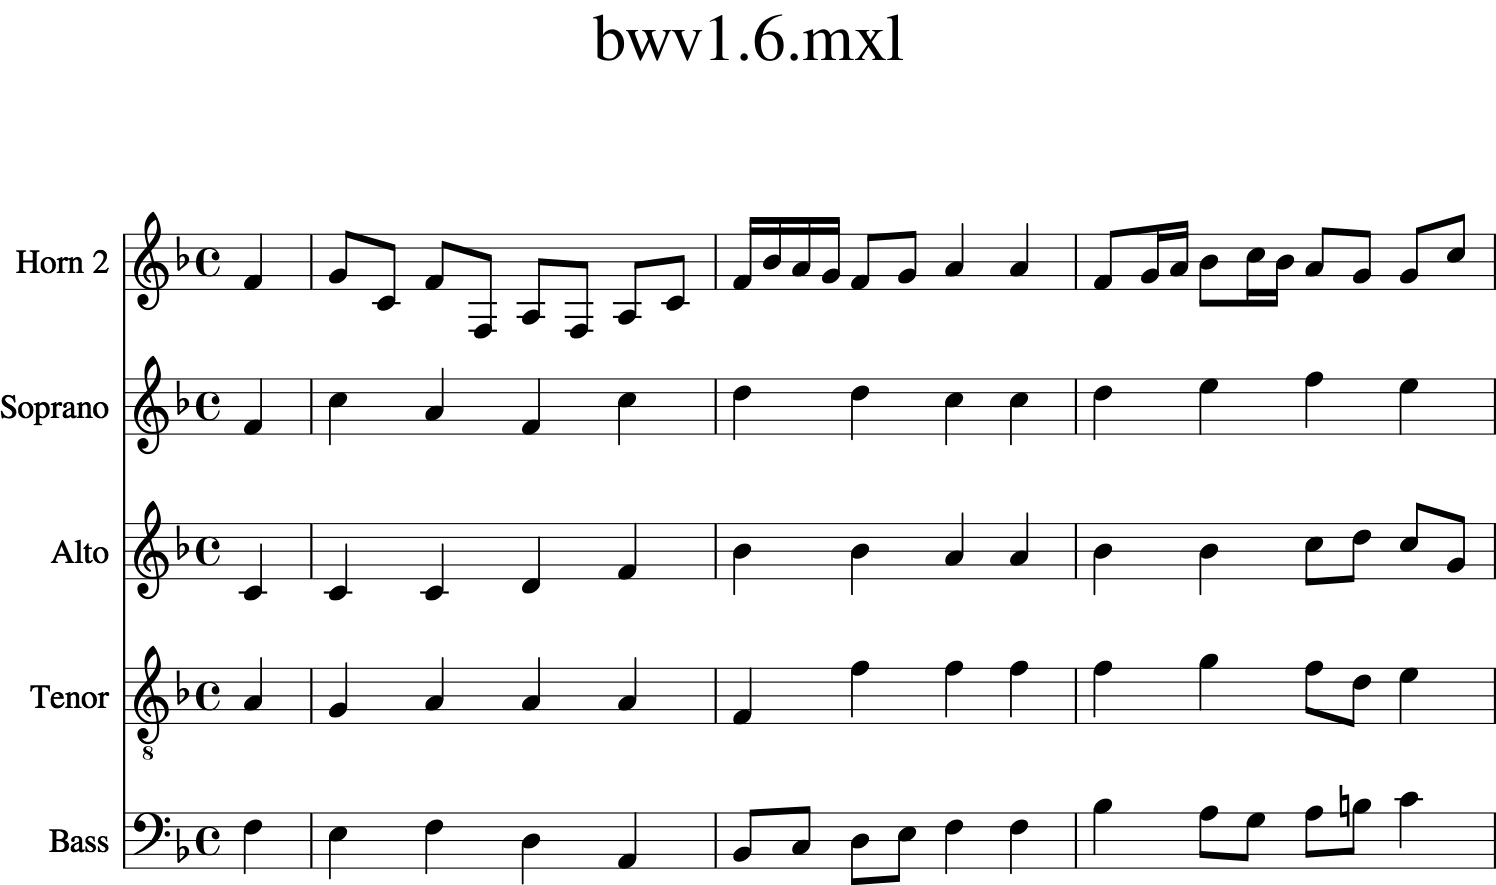

In [5]:
bwv1 = chorales[0].parse()
bwv1.measures(0, 3).show()

Hmmm... that looks like it's going to be in major...let's check to be reasonably sure:

In [6]:
bwv1.analyze('key')

<music21.key.Key of F major>

Okay, so this won't be relevant to us.  Let's parse a few pieces and find one in minor:

In [7]:
for i, chorale in enumerate(chorales[:20]):
    cScore = chorale.parse()
    if cScore.analyze('key').mode == 'minor':
        print(i, chorale)

1 <music21.metadata.bundles.MetadataEntry: bach_bwv10_7_mxl>
2 <music21.metadata.bundles.MetadataEntry: bach_bwv101_7_mxl>
3 <music21.metadata.bundles.MetadataEntry: bach_bwv102_7_mxl>
4 <music21.metadata.bundles.MetadataEntry: bach_bwv103_6_mxl>
6 <music21.metadata.bundles.MetadataEntry: bach_bwv108_6_mxl>
8 <music21.metadata.bundles.MetadataEntry: bach_bwv110_7_mxl>
9 <music21.metadata.bundles.MetadataEntry: bach_bwv111_6_mxl>
12 <music21.metadata.bundles.MetadataEntry: bach_bwv113_8_mxl>
13 <music21.metadata.bundles.MetadataEntry: bach_bwv114_7_mxl>


Ah, good ol' Bach has quite a bit in minor.  And now we know how to filter for the types of pieces we'll be interested in.  Let's grab BWV 10:

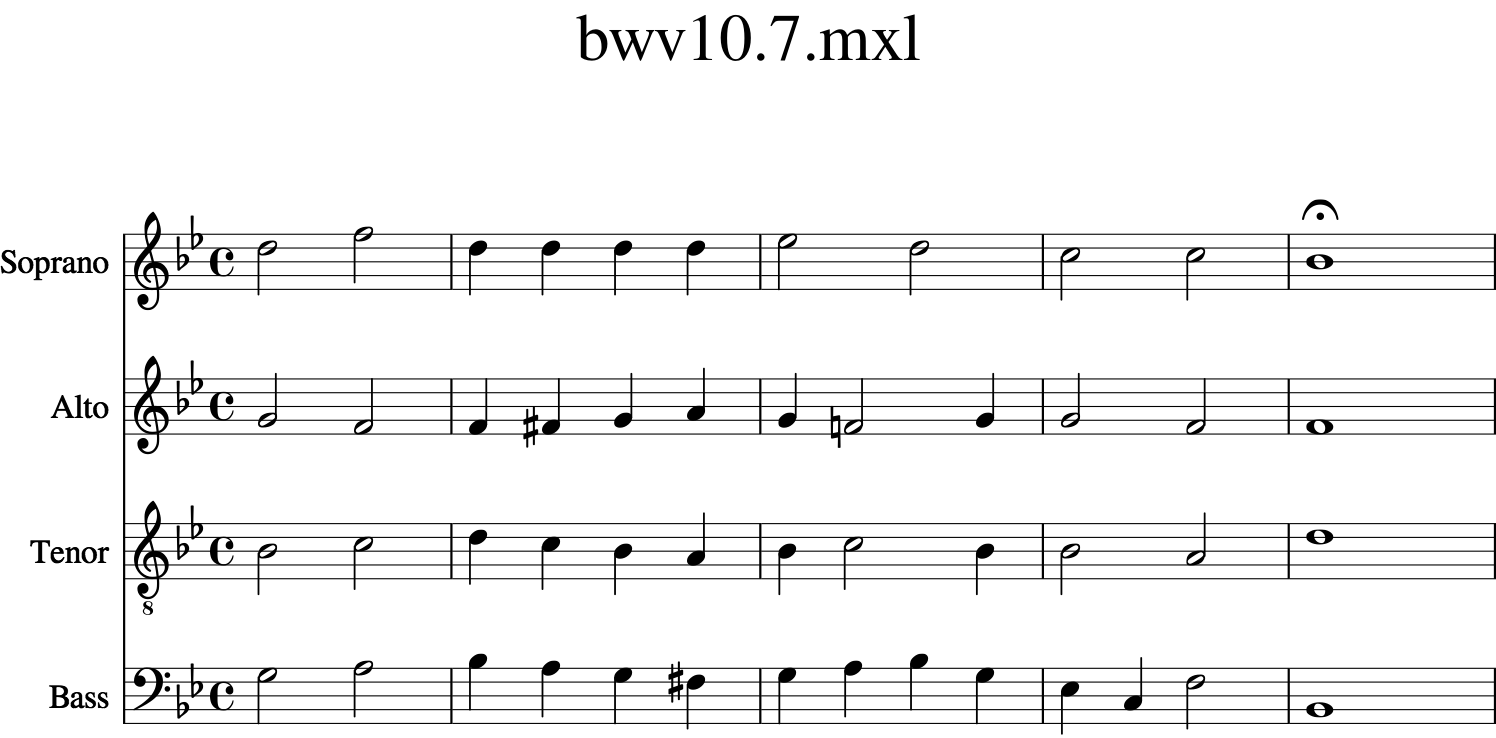

In [8]:
bwv10 = corpus.parse('bwv10')
bwv10.measures(0, 5).show()

Looks like it's in G minor with a first cadence on B-flat.  Perfect.  Let's look at the end also:

In [9]:
soprano = bwv10.parts[0]
len(soprano.getElementsByClass('Measure'))

22

Okay, there are 22 measures, so let's grab just measures 21 and 22:

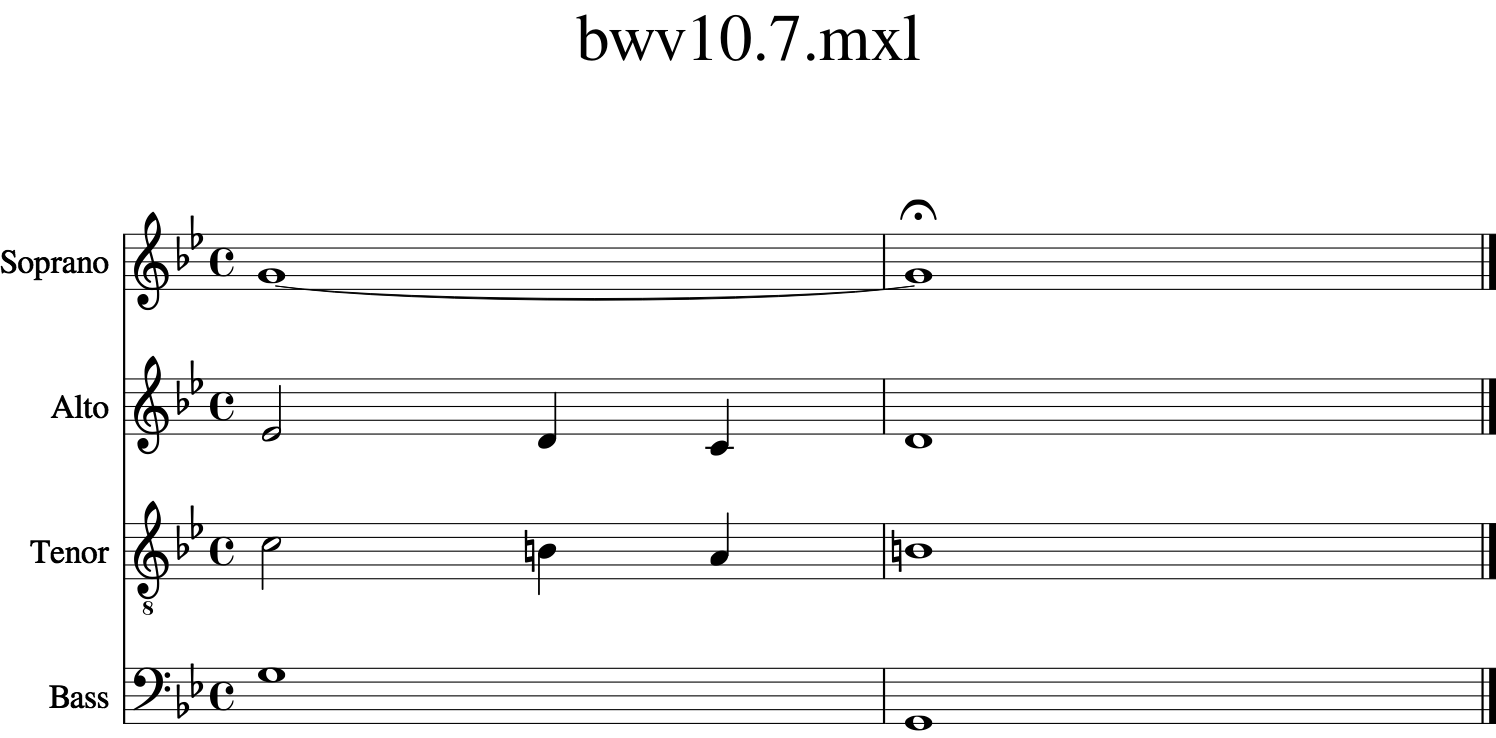

In [10]:
bwv10.measures(21, 22).show()

Looks like a nice Picardy third here.  Jean-Luc would be proud!  But let's see if `music21` can figure out that it's a major chord.  We could `chordify` the last measure, but let's instead get the last pitch from each part:

In [11]:
lastPitches = []

for part in bwv10.parts:
    lastPitch = part.pitches[-1]
    lastPitches.append(lastPitch)

lastPitches

[<music21.pitch.Pitch G4>,
 <music21.pitch.Pitch D4>,
 <music21.pitch.Pitch B3>,
 <music21.pitch.Pitch G2>]

This only works because Bach doesn't tend to end parts early and have rests at the end, but it wouldn't be too hard to compensate for something like that; I'll leave that as an exercise for determined programmers.

Okay, so let's make a chord out of those pitches, and lets make it a whole note

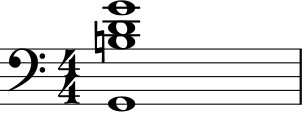

In [12]:
c = chord.Chord(lastPitches)
c.duration.type = 'whole'
c.show()

This could get ugly fast if the bass were any lower and the soprano were any higher, so let's put it in closed position:

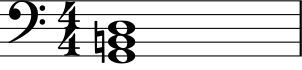

In [13]:
cClosed = c.closedPosition()
cClosed.show()

Well, that looks like a G-major chord to me.  But can music21 tell what it is?

In [14]:
cClosed.isMajorTriad()

True

In [15]:
cClosed.root()

<music21.pitch.Pitch G2>

Let's say that we're only interested in chords that end on the same root pitched as the analyzed key, so we can test for that too:

In [16]:
bwv10.analyze('key').tonic.name

'G'

In [17]:
cClosed.root().name

'G'

So we've figured out that BWV 10's chorale does what we generally expect Bach to do.  But where are the exceptions?  Let's look through the whole repertory and look for them.

Let's take some of the things that we've already done and make them into little functions.  First the function to get the last chord from a score:

In [18]:
def getLastChord(score):
    lastPitches = []

    for part in score.parts:
        lastPitch = part.pitches[-1]
        lastPitches.append(lastPitch)
    
    c = chord.Chord(lastPitches)
    c.duration.type = 'whole'
    
    cClosed = c.closedPosition()
    return cClosed

Let's check that we've coded that properly, by trying it on BWV 10:

In [19]:
getLastChord(bwv10)

<music21.chord.Chord G2 B2 D3>

Okay, now let's write a routine that takes in a score and sees if it is relevant.  It needs to be:

1. in minor
2. have a major last chord
3. have the root of the last chord be the same as the tonic of the analyzed key.

Let's try that, and return False if the piece is not relevant, but return the last chord if it is.

In [20]:
def isRelevant(score):
    analyzedKey = score.analyze('key')
    if analyzedKey.mode != 'minor':
        return False
    lastChord = getLastChord(score)
    if lastChord.isMinorTriad() is False:
        return False
    if lastChord.root().name != analyzedKey.tonic.name:
        return False
    else:
        return lastChord

Note that I've stored the result of the key analysis as a variable so that I don't need to run the same analysis twice.  Little things like this can speed up working with `music21` substantially.

Now let's look through some pieces and see which are relevant.  We'll store each chord in a Stream to show later, and we will add a lyric to the chord with the name of the piece:

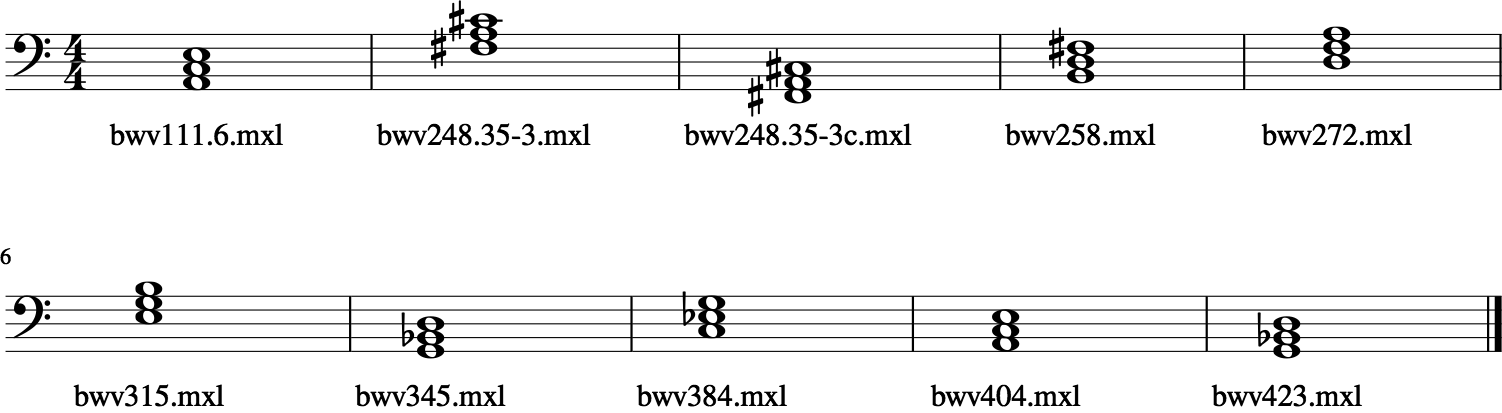

In [21]:
relevantStream = stream.Stream()
relevantStream.append(meter.TimeSignature('4/4'))

for chorale in chorales:
    score = chorale.parse()
    falseOrChord = isRelevant(score)
    if falseOrChord is not False:
        theChord = falseOrChord # rename for clarity
        theChord.lyric = score.metadata.title
        relevantStream.append(theChord)

relevantStream.show()

This is fun information to know about, but it's only here that the real research begins.  What about these pieces makes them special?  Well, BWV 111 was a cantata that was missing its chorale, so this has been traditionally added, but it's not definitively by Bach (the same chorale melody in the St. Matthew Passion has a Picardy third).  In fact, when we show the Chorale iterator later, it is a piece automatically skipped for that reason. BWV 248 is the Christmas oratorio (in the `music21` corpus twice, with and without continuo).  It definitely is a minor triad in the original manuscript, possibly because it does not end a section and instead goes back to the chorus da capo.

But what about the remaining seven examples?  They all have BWV numbers above 250, so they are part of the settings of chorales that were not connected to cantatas, sometimes called "orphan chorales."  Their possible use (as composition exercises? as studies for a proposed second Schemelli chorale aria collection?) and even their authenticity has been called into question before.  But the data from the `music21` collection argues against one hypothesis, that they were parts of otherwise lost cantatas that would have been similar to the existing ones.  No surviving cantata ends like these chorales do, so the evidence points to the idea that the orphan chorales were different in some other way than just being orphans, either as evidence that Bach's style had changed by the time he wrote them, or that they are not by Bach.

## Gap-Fill analysis

In a remarkable set of articles and other works from 1998-2000, Paul von Hippel explored the concept of "Gap-Fill," or the supposed idea that after a large leap in the melody, the listener expects that the following motion will be in the opposite direction, thereby filling the gap that was just created.  Hippel's work compared melodic motion to the average note height in a melody. When the melody leaps up it is often above the mean so there are more pitches available below the current note than above.  Similarly, when it leaps down, it is often below the mean, so there are more pitches above the current note than below.  Hippel's work showed that much or all of what we perceive to be gap-fill can be explained by "regression to the mean."  (The work is summarized beautifully in chapters 5 & 6 of David Huron's book _Sweet Anticipation_). But there are many repertories that have not yet been explored.  Let us see if there is a real Gap Fill or just regression to the mean in one piece of early fifteenth century music, using `Interval` objects as a guide.

First let's parse a piece that has been unedited except in the music21 corpus, a Gloria in the manuscript Bologna Q15 [(image available)](https://www.diamm.ac.uk/sources/117/#/images?p=45v) by a composer named "D. Luca".

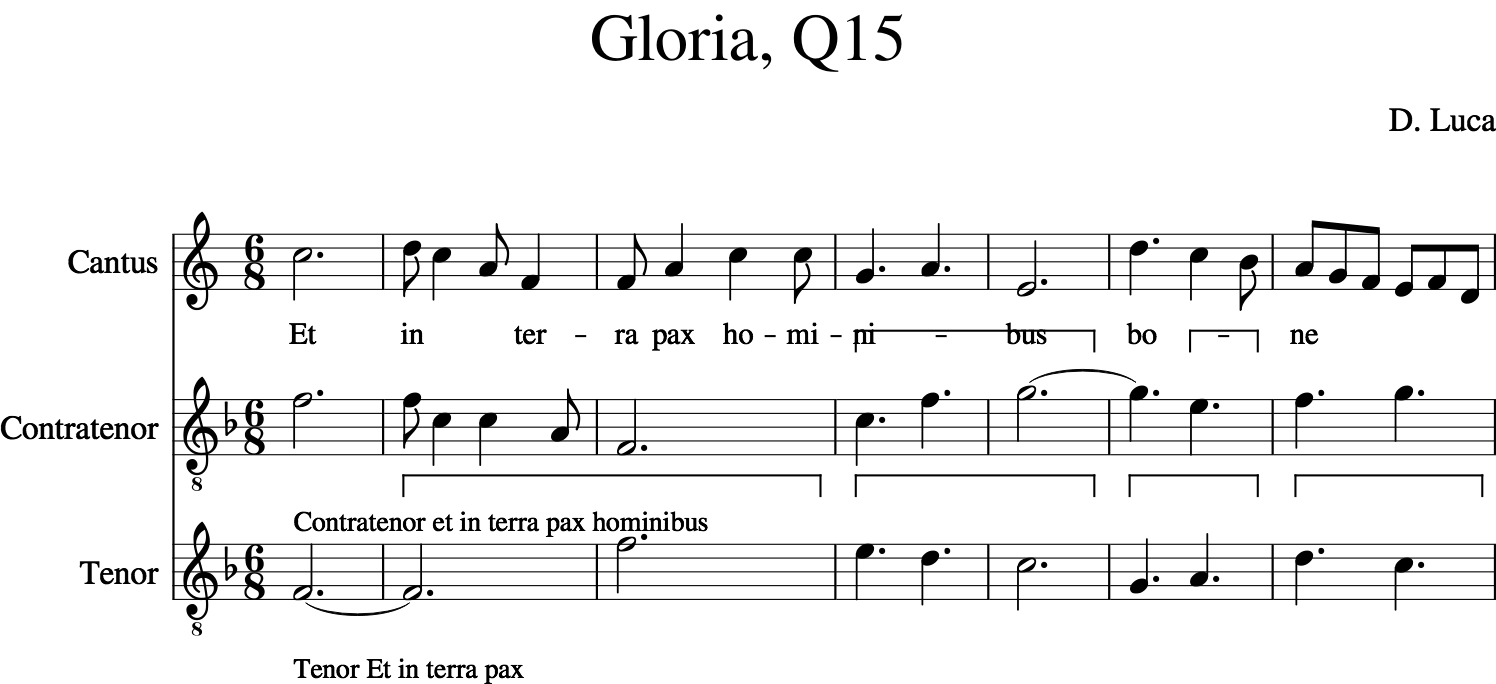

In [22]:
from music21 import *

luca = corpus.parse('luca/gloria')
luca.measures(1, 7).show()

For now, let's look at the top part alone:

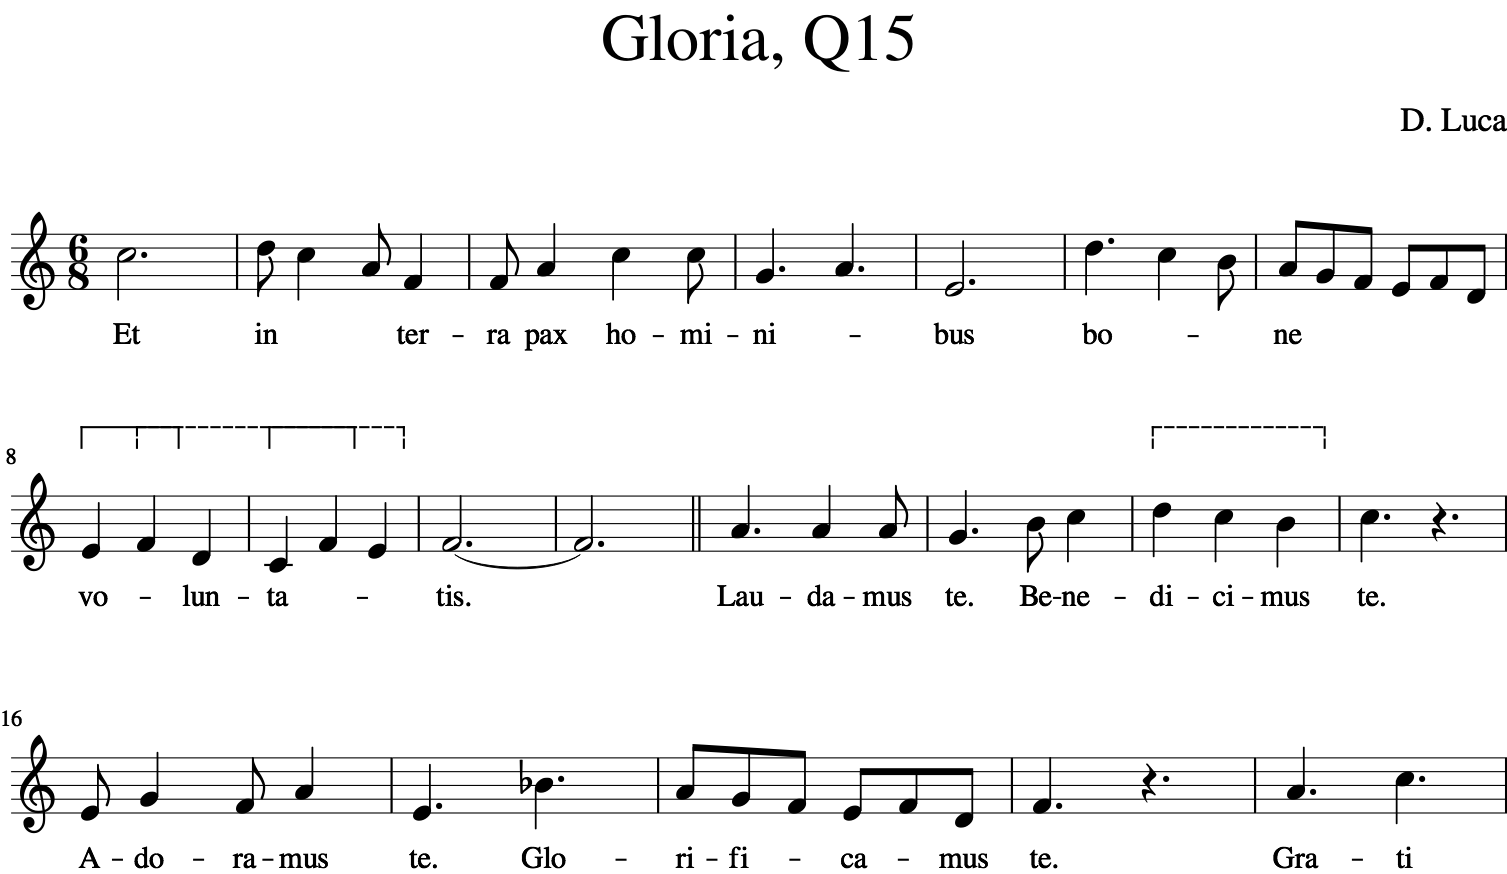

In [23]:
cantus = luca.parts['Cantus']
cantus.measures(1, 20).show()

Let us figure out the average pitch height in the excerpt by recursing through all the `Note` objects and finding getting the average of the `.ps` value, where Middle C = 60.  (Similar to the `.midi` value)

In [24]:
totalNotes = 0
totalHeight = 0
for n in cantus.recurse().getElementsByClass('Note'):
    totalNotes += 1
    totalHeight += n.pitch.ps
averageHeight = totalHeight/totalNotes
averageHeight

67.41100323624596

We can figure out what approximately what note that is by creating a new `Note` object:

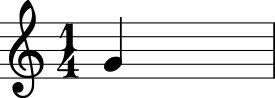

In [25]:
averageNote = note.Note()
averageNote.pitch.ps = round(averageHeight)
averageNote.show()

(It's possible to get a more exact average pitch, if we care about such things, when we get to microtones later...)

In [26]:
exactAveragePitch = pitch.Pitch(ps=averageHeight)
exactAveragePitch.step

'G'

In [27]:
exactAveragePitch.accidental

<accidental half-sharp>

In [28]:
exactAveragePitch.microtone

(-9c)

For users of Python 3, there are some even easier ways to get the average pitch, using the mean or the median:

In [29]:
import statistics
statistics.mean([p.ps for p in cantus.pitches])

67.41100323624596

In [30]:
statistics.median([p.ps for p in cantus.pitches])

67.0

Medians are usually more useful than means in doing statistical analysis, so we'll use medians for our remaining analyses:

In [31]:
medianHeight = statistics.median([p.ps for p in cantus.pitches])

Okay, now let us get all the intervals in a piece.  We'll do this in an inefficient but easy to follow manner first and then later we can talk about adding efficiencies.  We'll recurse through the `Part` object and get the `.next()` :class:`~music21.note.Note` object each time and create an interval for it.

In [32]:
allIntervals = []
for n in cantus.recurse().getElementsByClass('Note'):
    nextNote = n.next('Note')
    if nextNote is None: # last note of the piece
        continue
    thisInterval = interval.Interval(n, nextNote)
    allIntervals.append(thisInterval)

Let's look at some of the intervals and also make sure that the length of our list makes sense:

In [33]:
allIntervals[0:5]

[<music21.interval.Interval M2>,
 <music21.interval.Interval M-2>,
 <music21.interval.Interval m-3>,
 <music21.interval.Interval M-3>,
 <music21.interval.Interval P1>]

In [34]:
len(allIntervals)

308

In [35]:
len(cantus.recurse().getElementsByClass('Note'))

309

Let's look at that first Interval object in a bit more detail to see some of the things that might be useful:

In [36]:
firstInterval = allIntervals[0]
firstInterval.noteStart

<music21.note.Note C>

In [37]:
firstInterval.noteEnd

<music21.note.Note D>

In [38]:
firstInterval.direction

<Direction.ASCENDING: 1>

We are only going to be interested in intervals of a third or larger, so let's review how to find generic interval size:

In [39]:
firstInterval.generic

<music21.interval.GenericInterval 2>

In [40]:
firstInterval.generic.directed

2

In [41]:
secondInterval = allIntervals[1]
secondInterval.generic.directed

-2

In [42]:
secondInterval.generic.undirected

2

In order to see whether gap-fill or regression to the mean is happening at any given moment, we need to only look at leaps up that after the leap are still below the mean or leaps down that finish above the mean.  For instance, if a line leaps up and is above the mean then both the gap-fill and the regression to the mean hypothesis would predict a downward motion for the next interval, so no knowledge would be gained.  But if the line leaps up and is below the mean then the gap-fill hypothesis would predict downward motion, but the regression to the mean hypothesis would predict upward motion for the next interval.  So motion like this is what we want to see.

Let's define a function called `relevant()` that takes in an interval and says whether it is big enough to matter and whether the gap-fill and regression hypotheses predict different motions:

In [43]:
def relevant(thisInterval):
    if thisInterval.generic.undirected < 3:
        return False
    noteEndPs = thisInterval.noteEnd.pitch.ps
    if thisInterval.direction == interval.Direction.ASCENDING and noteEndPs < medianHeight:
        return True
    elif thisInterval.direction == interval.Direction.DESCENDING and noteEndPs > medianHeight:
        return True
    else:
        return False

There won't be too many relevant intervals in the piece:

In [44]:
[relevant(i) for i in allIntervals].count(True)

22

In [45]:
[relevant(i) for i in allIntervals[0:10]]

[False, False, True, False, False, False, False, False, False, False]

The third interval is relevant.  Let's review what that interval is.  It's the C5 descending to A4, still above the average note G4.  Gap-fill predicts that the next note should be higher, regression predicts that it should be lower.

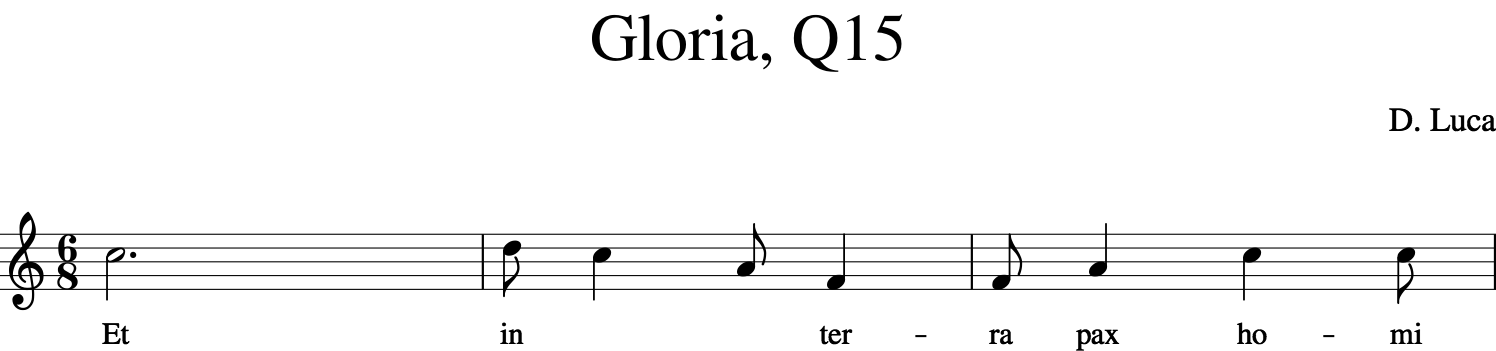

In [46]:
cantus.measures(1, 3).show()

In this case, the regression to the mean hypothesis is correct and the gap-fill hypothesis is wrong.  But that's just one case, and these sorts of tests need to take in many data points.  So let us write a function that takes in a relevant interval and the following interval and says whether gap-fill or regression is correct.  We will return 1 if gap-fill is correct, 2 if regression is correct, or 0 if the next interval is the same as the current.

In [47]:
def whichHypothesis(firstInterval, secondInterval):
    if secondInterval.direction == interval.Direction.OBLIQUE:
        return 0
    elif secondInterval.direction != firstInterval.direction:
        return 1
    else:
        return 2


In [48]:
whichHypothesis(allIntervals[2], allIntervals[3])

2

We can run this analysis on the small dataset of 32 relevant intervals in the cantus part.  We will store our results in a three-element list containing the number of oblique intervals, the number that fit the gap-fill hypothesis, and the number which fit the regression hypothesis:

In [49]:
obliqueGapRegression = [0, 0, 0]

for i in range(len(allIntervals) - 1):
    thisInterval = allIntervals[i]
    nextInterval = allIntervals[i + 1]
    if not relevant(thisInterval):
        continue
    hypothesis = whichHypothesis(thisInterval, nextInterval)
    obliqueGapRegression[hypothesis] += 1
    
obliqueGapRegression, obliqueGapRegression[1] - obliqueGapRegression[2]

([6, 10, 6], 4)

So for this small set of data, gap-fill is more predictive than regression.  Let's run it on the whole piece.  First we will need to redefine `relevant` to take the average pitch height as a parameter.

In [50]:
def relevant2(thisInterval, medianHeight):
    if thisInterval.generic.undirected < 3:
        return False
    noteEndPs = thisInterval.noteEnd.pitch.ps
    if thisInterval.direction == interval.Direction.ASCENDING and noteEndPs < medianHeight:
        return True
    elif thisInterval.direction == interval.Direction.DESCENDING and noteEndPs > medianHeight:
        return True
    else:
        return False

And let's define a function that computes hypothesisTotal for a single part.

In [51]:
def onePartHypothesis(part):
    obliqueGapRegression = [0, 0, 0]

    medianHeight = statistics.median([p.ps for p in part.pitches])
    allIntervals = []
    for n in part.recurse().getElementsByClass('Note'):
        nextNote = n.next('Note')
        if nextNote is None: # last note of the piece
            continue
        thisInterval = interval.Interval(n, nextNote)
        allIntervals.append(thisInterval)
    
    for i in range(len(allIntervals) - 1):
        thisInterval = allIntervals[i]
        nextInterval = allIntervals[i + 1]
        if not relevant2(thisInterval, medianHeight):
            continue
        hypothesis = whichHypothesis(thisInterval, nextInterval)
        obliqueGapRegression[hypothesis] += 1

    return obliqueGapRegression

When I refactor, I always make sure that everything is still working as before:

In [52]:
onePartHypothesis(cantus)

[6, 10, 6]

Looks good! Now we're ready to go:

In [53]:
obliqueGapRegression = [0, 0, 0]

for p in luca.parts:
    onePartTotals = onePartHypothesis(p)
    obliqueGapRegression[0] += onePartTotals[0]
    obliqueGapRegression[1] += onePartTotals[1]
    obliqueGapRegression[2] += onePartTotals[2]
    
obliqueGapRegression, obliqueGapRegression[1] - obliqueGapRegression[2]

([7, 20, 28], -8)

The lower two parts overwhelm the first part and it is looking like regression to the mean is ahead. But it's only one piece!  Let's see if there are other similar pieces in the corpus.  There's a collection of works from the 14th century, mostly Italian works: 

In [54]:
corpus.search('trecento')

<music21.metadata.bundles.MetadataBundle {103 entries}>

Let's run 20 of them through this search and see how they work!

In [55]:
obliqueGapRegression = [0, 0, 0]

for trecentoPieceEntry in corpus.search('trecento')[:20]:
    parsedPiece = trecentoPieceEntry.parse()
    for p in parsedPiece.parts:
        onePartTotals = onePartHypothesis(p)
        obliqueGapRegression[0] += onePartTotals[0]
        obliqueGapRegression[1] += onePartTotals[1]
        obliqueGapRegression[2] += onePartTotals[2]
    
obliqueGapRegression, obliqueGapRegression[1] - obliqueGapRegression[2]

([27, 86, 84], 2)

So it looks like neither the gap-fill hypothesis or the regression to the mean hypothesis are sufficient in themselves to explain melodic motion in this repertory.  In fact, a study of the complete encoded works of Palestrina (replace 'trecento' with 'palestrina' in the search and remove the limitation of only looking at the first 20, and wait half an hour) showed that there were 12,089 relevant instances, with 2334 followed by a unison, but 5130 exhibiting gap-fill behavior and only 4625 following regression to the mean, with a difference of 5.2%.  This shows that regression to the mean cannot explain all of the reversion after a leap behavior that is going on in this repertory.  I'm disappointed because I loved this article, but it'll come as a relief to most teachers of modal counterpoint.

Whew! There's a lot here in these two examples, and I hope that they point to the power of corpus analysis with `music21`, but we still have quite a lot to sort through, so we might as well continue by understanding how `music21` sorts objects in :ref:`Chapter 21: : Ordering and Sorting of Stream Elements <usersGuide_21_sorting>`.